In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss
from deeponet import DeepONet
from gru2 import GRUModel

In [2]:
x = np.loadtxt("x.dat", np.float32)
y = np.loadtxt("y.dat", np.float32)
x = x.reshape(x.shape[0], x.shape[1]//2, 2)
y = y.reshape(y.shape[0], y.shape[1]//1, 1)
grid = np.linspace(0, 1, 100, dtype=np.float32).reshape((100, 1))

print(x.shape)
print(y.shape)
print(grid.shape)

(1000, 100, 2)
(1000, 100, 1)
(100, 1)


In [3]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

grid_repeated = []
for i in range(batch_size):
    grid_repeated.append(grid)
grid_repeated = torch.from_numpy(np.array(grid_repeated)).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
branch = nn.Sequential(
    GRUModel(100, 2, 256))

trunk = nn.Sequential(
          nn.Linear(1, 64),
          nn.ReLU(),
          nn.Linear(64,128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
        )

In [7]:
model = DeepONet(branch, trunk).cuda()
print(count_params(model))

98528


In [8]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [9]:
loss = LpLoss()
train_lossArr = []
test_lossArr = []
time_Arr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x, grid_repeated)
        
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x, grid_repeated)
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))

0 0.27451252308674157 0.6195161269770728 0.5088271856307983
50 0.12113516801036894 0.03830909091565344 0.040877511352300645
100 0.1316052721813321 0.019356992695894505 0.015407547913491726
150 0.0901825469918549 0.014942130446434021 0.012988816015422344
200 0.0919344499707222 0.010009666325317489 0.009972028248012067
250 0.08872029697522521 0.010079586205797063 0.015186993591487407
300 0.09100263891741633 0.007565311994403601 0.006910804845392704
350 0.08941261889412999 0.005882708914577961 0.007754014246165753
400 0.0983832951169461 0.0057005845424201755 0.005659175105392933
450 0.0935728088952601 0.005145497056138184 0.005646455846726894
500 0.08871634001843631 0.004654416974840893 0.004922724794596434
550 0.09251102502457798 0.00453056573557357 0.005130150262266398
600 0.08987063798122108 0.0042480448053942785 0.004692950518801808
650 0.09035864705219865 0.00432846384226448 0.0048551752232015135
700 0.08915152680128813 0.0041346274575011594 0.004390284977853298
750 0.088743010070174

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


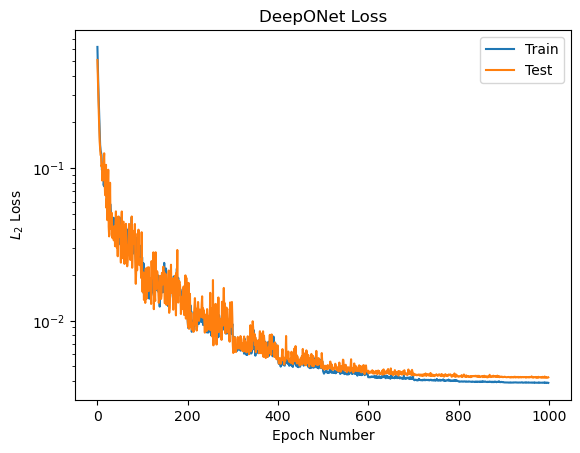

In [10]:
plt.plot(train_lossArr, label="Train")
plt.plot(test_lossArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.title("DeepONet Loss")
plt.legend()
plt.savefig("deeponetLinearLoss.eps")

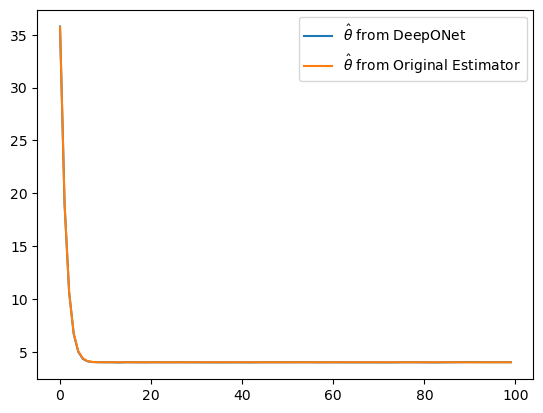

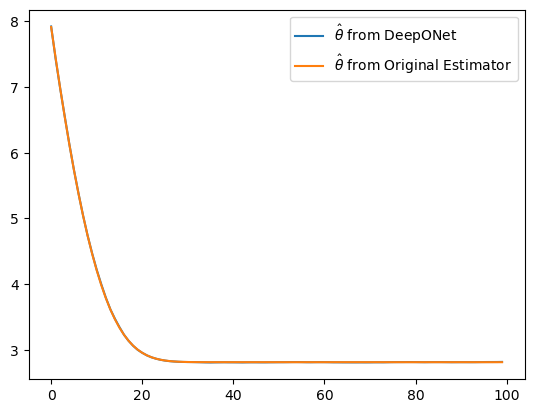

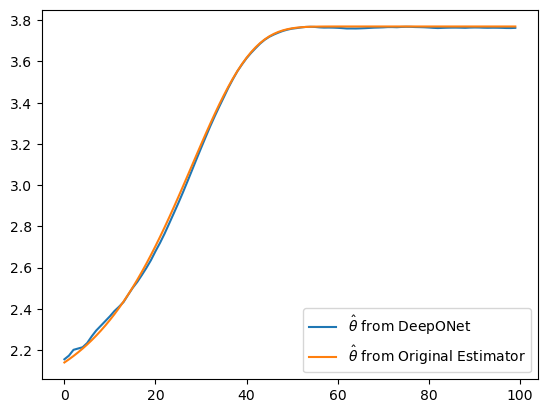

In [16]:
# Show some examples
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x, grid_repeated)
        
    for i in range(3):
        plt.figure()
        plt.plot(out[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from DeepONet")
        plt.plot(y[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from Original Estimator")
        plt.legend()

In [18]:
with torch.no_grad():
    out_theta = []
    guess_theta = []
    test_loss = 0
    loss_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x, grid_repeated)
        out = out.reshape((out.shape[0], out.shape[1]))
        
        for i in range(len(y)):
            out_theta.append(y[i][-1].cpu().detach())
            guess_theta.append(out[i][-1].cpu().detach())
            loss_end += (out_theta[-1]-guess_theta[-1])**2
        
        test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print("TEST MSE:", test_loss/len(testData))
print("TEST MSE FINAL VALUE:", loss_end.item()/len(testData))

TEST MSE: 0.004241986945271492
TEST MSE FINAL VALUE: 0.0018465837463736534


Text(0, 0.5, 'Final $\\hat{\\theta}$ from DeepONet')

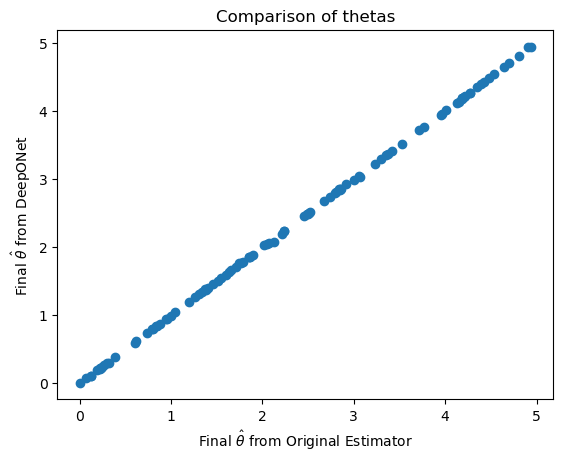

In [17]:
plt.title("Comparison of thetas")
plt.scatter(out_theta, guess_theta)
plt.xlabel(r"Final $\hat{\theta}$ from Original Estimator")
plt.ylabel(r"Final $\hat{\theta}$ from DeepONet")

In [14]:
# Save Model
torch.save(model.state_dict(), "deeponet1")